The notebook outlines the telescope pointing routine to a LEO satellite from NORAD catalogue based on Two-Line Elements (TLE) data. The illustration below shows the baseline geometry of the mathematical model.

<!-- ![pointing_geometry.png](attachment:pointing_geometry.png) -->
<img src="pointing_geometry.png" width="500" height="340"> 

Two reference frameы are depicted. Earth-centered Earth-fixed (ECEF) denoted as $\textit{OXYZ}$ is used to specify the location of the observatory on the Earth. Local reference frame $\textit{oxyz}$ originates at the observatory location, x-axis points toward North, z-axis points to zenith direction, y-axis completes orthonormal reference frame to the right-handed triad. The reference frame is used to specify azimuth $\alpha$ and elevation $\beta$ of a satellite as seen from the observatory location.

$\mathbf{R}_{obs}$ represents observatory position vector given ECEF frame $\textit{OXYZ}$.

$\mathbf{R}_{sat}$ represents satellites position vector given ECEF frame $\textit{OXYZ}$.

In order to find azimuth and elevation of a satellite for a particular time step the following procedure is used:

1. Propagate satellite state to obtain satellite position $\mathbf{R}_{sat}$ at time t. 
    Let us use SGP4 propagator that utilizes NORAD TLE as an input as a standard in the aerospace industry. The SGP4 outputs position and velocity given in ECI frame (TEME). It should be converted to ECEF frame where there observatory location is represented.
2. Find vector $\mathbf{r}$ pointing from the observatory to the satellite.
3. Find satellite azimuth $\alpha$ and elevation $\beta$ as seen from the observatory by transforming $\mathbf{r}$ to local reference frame $\textit{oxyz}$ and then calculating the required angles as shown in illustration above.
   
Repeat the routine to obtain relative satellite trajectory arc, namely $\alpha(t)$, $\beta(t)$.

In order to find a set of satellites visible at the observatory for a given time span $\Delta t$ the following procedure is used:
1. Propagate satellite state for the time span $\Delta t$
2. Convert observatory position vector to ECI frame to for a given time span for further line-of-sight analysis
3. Calculate satellite elevation $\beta$ during the time span
4. A set of satellites is defined by the constraint $\beta > \beta_{min}$, where $\beta_{min}$ is critical satellite elevation for the observations.

TLE data can be accessed via the link https://celestrak.org/NORAD/elements/


TODO:
1. Check SGPF4 documentation and provide propagator precison position. Add data to the notebook description (Fatima, Shamil)
2. A routine to calculate satellite elevation and discard a satellite if it has no elevation above certain threshold, $\beta_{min}$ (Shami, Fatima)
3. For a feasible satellite provide satellite position data for viable observation time when satellite is above minimum required elevation (Shamil, Fatima)

In [42]:
from consts import *
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import statistics

# Defines location of the observatory 
# Data are taken from google map, Add data from Konstantin
latitude_obs = 24.178416871640632 * np.pi / 180
longitude_obs = 54.68951437347364 * np.pi / 180

# The position vector is given for the case of spherical Earth, meaning Earth oblateness is not taken into account. This can be later improved
r_obs_ecef = np.vstack([Consts.rEarth * np.cos(latitude_obs) * np.cos(longitude_obs), Consts.rEarth * np.cos(latitude_obs) * np.sin(longitude_obs), Consts.rEarth * np.sin(latitude_obs)])  

r_obs_ecef_mag = np.linalg.norm(r_obs_ecef)

elevation_min = np.pi/6

# print(r_obs_ecef, r_obs_ecef_mag)

Matplotlib is building the font cache; this may take a moment.


In [43]:
# Define observation time span

from datetime import datetime, timedelta
from astropy.time import Time
import pandas as pd

# Define start and end date with specific time
# Datetime is given in UTC format
# Abu Dhabi time zone is UTC+4

start_date = "2024-11-01 13:00:00" # given in UTC
end_date = "2024-11-01 15:00:00"   # given in UTC

# Generates a range of datetimes with certain time step
t_span = pd.date_range(start=start_date, end=end_date, freq='30s')

# Converts to a list of strings if needed?
gregorian_dates = t_span.strftime("%Y-%m-%d %H:%M:%S").tolist()

# Converts to Julian Date
julian_dates = Time(gregorian_dates, format='iso').jd

# print(gregorian_dates)

variance r_obs_mag 2.799020628014364e-07 
 variance r_obs_z 3033710.835760963


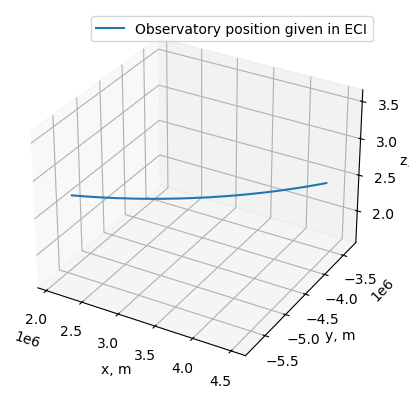

In [44]:
# Calculates station coordinates in ECI for the given time span

from conversions import *

r_obs_eci_array = np.empty([3, 0], float)

for t in t_span:
    r_obs_eci_array = np.concatenate((r_obs_eci_array, ecef_to_eci(r_obs_ecef, t)), axis=1)


r_obs_eci_mag_array = np.linalg.norm(r_obs_eci_array, axis=0)

var_r_obs_mag = statistics.variance(r_obs_eci_mag_array) # shows position vector change, which is small enough
var_r_obs_z = statistics.variance(r_obs_eci_array[2,:]) # show the z coordinate change
print('variance r_obs_mag', var_r_obs_mag, '\n', 'variance r_obs_z', var_r_obs_z)

# fig, ax = plt.subplots()
# ax.plot(t_span, r_obs_eci_mag_array)
# plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(r_obs_eci_array[0,:], r_obs_eci_array[1,:], r_obs_eci_array[2,:], label='Observatory position given in ECI')
ax.set(xlabel='x, m', ylabel='y, m', zlabel='z, m')
ax.axis('equal') # makes the same axes scale
ax.grid()
ax.legend()
plt.show()
# plt.savefig("Observatory position trajectory.pdf")


# fig, ax = plt.subplots()
# ax.plot(t_span, r_obs_eci_array[2,:])

# ax.set(xlabel='time, UTC', ylabel='z obs, m',
#        title='observer z coordinate change')
# ax.grid()
# plt.show()

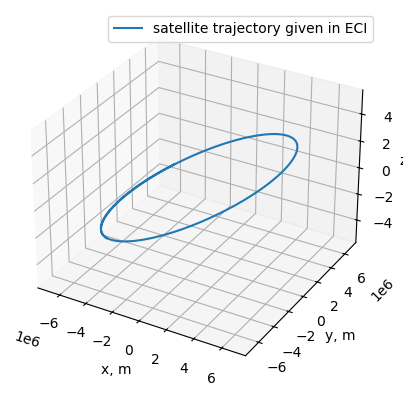

[-4898044.78672443 -3657530.64209398 -3263954.173544  ]


<Figure size 640x480 with 0 Axes>

In [109]:
# Propagates satellite state using SGP4 propagator for the given time span

from sgp4.api import Satrec

s = "1 44714U 19074B   24303.16471469  .00014028  00000+0  95926-3 0  9999"
t = "2 44714  53.0541 255.6079 0001757  96.6875 263.4314 15.06381615274085"

satellite = Satrec.twoline2rv(s, t)

# Propagates satellite state for the t_span
positionsX = []
positionsY = []
positionsZ = []

r_sat_eci_array = np.empty([3, 0], float)

for jd in julian_dates:

    # Propagate
    e, r, v = satellite.sgp4(jd, 0)
    
    if e == 0:
        positionsX.append(r[0] * 1e3)
        positionsY.append(r[1] * 1e3)
        positionsZ.append(r[2] * 1e3)
    
        r_sat_eci_array = np.concatenate((r_sat_eci_array, np.vstack([r[0] * 1e3, r[1] * 1e3, r[2] * 1e3])), axis=1)

    else:
        positionsX.append(None)  # Error in propagation
        positionsY.append(None)  # Error in propagation
        positionsY.append(None)  # Error in propagation

gregorian_dates = Time(julian_dates, format='jd').to_datetime()

sat1Data = np.array([gregorian_dates, positionsX, positionsY, positionsZ]).T

sat1 = pd.DataFrame(sat1Data, columns=["Date and Time", "X, km", "Y, km", "Z, km"])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(r_sat_eci_array[0,:], r_sat_eci_array[1,:], r_sat_eci_array[2,:], label='satellite trajectory given in ECI')
ax.set(xlabel='x, m', ylabel='y, m', zlabel='z, m')
ax.grid()
ax.axis('equal')
ax.legend()
plt.show()
plt.savefig("satellite trajectory.png")

print(r_sat_eci_array[:, 0])
# print("Satellite 1 Position Data")
# print(sat1)

# print(np.size(r_sat_eci_array, axis=1))

241


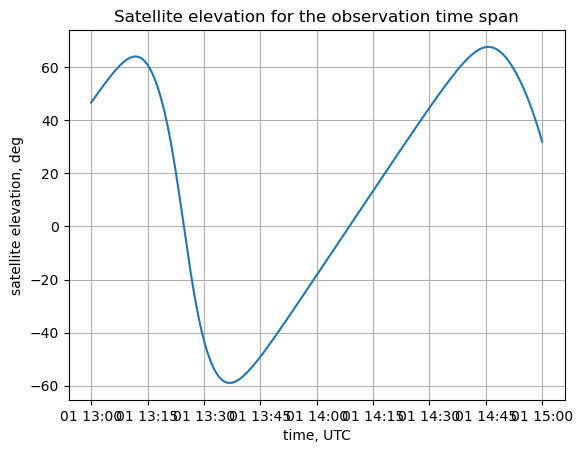

In [111]:
# Calculates satellite elevation for the given t_span
# Check if satellite goes above minimum required elevation

elevation_array = []
elevation_array_deg = []

print(np.size(r_sat_eci_array, axis=1))

for time_idx in range(np.size(julian_dates)):

    r_relative = r_sat_eci_array[:, time_idx] - r_obs_eci_array[:, time_idx]
    e_relative = r_relative / np.linalg.norm(r_relative)
    e_sat = r_sat_eci_array[:, 0] / np.linalg.norm(r_sat_eci_array[:, 0])

    elevation_array.append(np.pi / 2 - np.arccos(np.dot(e_sat, e_relative)))
    elevation_array_deg.append((np.pi / 2 - np.arccos(np.dot(e_sat, e_relative))) * 180 / np.pi)

condition = elevation_array > np.repeat(0, np.size(julian_dates))

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(t_span, elevation_array_deg)

ax.set(xlabel='time, UTC', ylabel='satellite elevation, deg',
       title='Satellite elevation for the observation time span')
ax.grid()

fig.savefig("satellite elevation.png")
plt.show()

In [95]:
import numpy as np
from calc_local_bases_axes import *

lat = 0
lon = 0
print(lat, lon)

A = calc_local_bases_axes(lat, lon)

print(A)
Rsat = np.vstack([positionsX[0], positionsY[0], positionsZ[0]])

r = Rsat - r_obs_ecef

rTransformed = np.matmul(A, r)

az, decl = calc_local_azimuth_and_declination(rTransformed)

# print(r)

# print(rTransformed)

print(az * 180 / np.pi, decl * 180 / np.pi)

0 0
[[-0.  1.  0.]
 [-0. -0.  1.]
 [ 1.  0.  0.]]
[124.96047213] [-4.50317828e-06]


DatetimeIndex(['2024-11-01 13:00:00', '2024-11-01 13:00:30',
               '2024-11-01 13:01:00', '2024-11-01 13:01:30',
               '2024-11-01 13:02:00', '2024-11-01 13:02:30',
               '2024-11-01 13:03:00', '2024-11-01 13:03:30',
               '2024-11-01 13:04:00', '2024-11-01 13:04:30',
               ...
               '2024-11-01 14:55:30', '2024-11-01 14:56:00',
               '2024-11-01 14:56:30', '2024-11-01 14:57:00',
               '2024-11-01 14:57:30', '2024-11-01 14:58:00',
               '2024-11-01 14:58:30', '2024-11-01 14:59:00',
               '2024-11-01 14:59:30', '2024-11-01 15:00:00'],
              dtype='datetime64[ns]', length=241, freq='30s')


ValueError: x and y must have same first dimension, but have shapes (241,) and (1,)

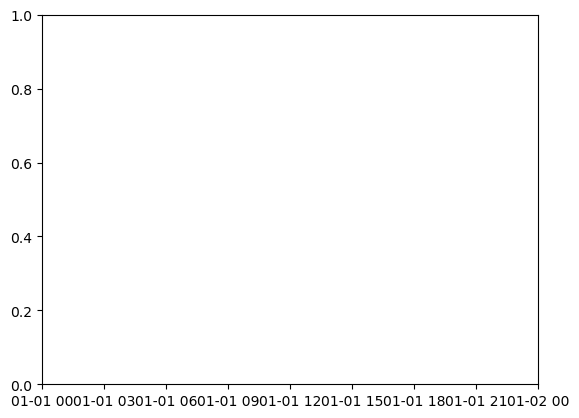

In [122]:
# define sun elevation angle with respect to observation point 
from skyfield.api import load, Topos

# Load ephemeris data (required for accurate positions)
eph = load('de421.bsp')  # DE421 ephemeris, can be downloaded by Skyfield if not already cached
earth, sun = eph['earth'], eph['sun']

# Compute Sun's position relative to Earth
sunElevationArray =  []
for jdIndx, jd in enumerate(julian_dates):
    astrometric = earth.at(ts.tt_jd(jd)).observe(sun)
    distance, sun_vector = astrometric.distance().km, astrometric.position.km  # Get position vector in km
    eSun = sun_vector / np.linalg.norm(sun_vector)
    eObs = r_obs_eci_array[:, jdIndx] / np.linalg.norm(r_obs_eci_array[:, jdIndx])
 
    sunElevation = np.pi / 2 - np.arccos(np.dot(eObs, eSun))

    sunElevationArray_deg = np.concatenate((sunElevationArray, np.array(sunElevation * 180 / np.pi).reshape(1)), axis=0)
# Display results
#print("Sun's Position Vector (km):", sun_vector)

print(t_span)
fig, ax = plt.subplots()
ax.plot(t_span, np.transpose(sunElevationArray_deg))

ax.set(xlabel='time, UTC', ylabel='satellite elevation, deg',
       title='Satellite elevation for the observation time span')
ax.grid()

fig.savefig("satellite elevation.png")
plt.show()